In [139]:
from dataprep import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot

In [2]:
## Process data and create initial dataFrame
cgm_data = DataCleaning()

In [3]:
## Only run the below if you want to rebuild your data file - due to the size of the source this can take up to an hour to run
#cgm_data.resequenceData(size=3)

Warning - This function will take a while to complete as it is creating sequences based on multiple variables in the data file. Please be patient.


## EDA for Project Section

In [14]:
## load dataframe from cleaned data
CGMDf = pd.read_csv('/Users/bsw/Documents/MRPLocal/DATA/CGM_Processed.csv')
CGMDf.head()

Unnamed: 0.1                   int64
index                          int64
Unnamed: 0                     int64
RecID                          int64
PtID                           int64
ParentCITYDeviceUploadsID      int64
DeviceDtTm                    object
RecordType                    object
Value                        float64
Units                         object
SortOrd                      float64
ValueMMOL                    float64
DDate                         object
hourOfDay                      int64
series                          bool
series_id                      int64
dtype: object

### Cleaning up data for simplicity

In [15]:

## drop unnecessary columns to save on space / compute
CGMDf.drop(['Unnamed: 0.1','index','Unnamed: 0','RecordType','Value'], inplace=True, axis=1)

## cleaning up the data -- Resetting data types
CGMDf['DDate']=pd.to_datetime(CGMDf['DDate'])
CGMDf['DeviceDtTm']=pd.to_datetime(CGMDf['DeviceDtTm'])
CGMDf.SortOrd=CGMDf.SortOrd.astype(int)

## cleaning data - removing series where not enough samples to learn / predict
a=pd.DataFrame(CGMDf.groupby(['PtID','series_id'])['RecID'].count())
a.reset_index(inplace=True)
CGMDf = CGMDf[~CGMDf.series_id.isin(a.series_id[a.RecID<=25].to_list())] ## Remove series where there will be no ability to forecast more than 5 datapoints
CGMDf.shape[0]
## 1 950 448 -- samples remaining


In [101]:
## looking at remaining structured data
CGMDf.head()

,RecID,PtID,ParentCITYDeviceUploadsID,DeviceDtTm,Units,SortOrd,ValueMMOL,DDate,hourOfDay,series,series_id
0,1539485,39,651,2000-04-21 04:31:56,mg/dL,7880,7.5,2000-04-21,4,False,73331
1,1539486,39,651,2000-04-21 04:36:55,mg/dL,7881,7.4,2000-04-21,4,False,73331
2,1539487,39,651,2000-04-21 04:41:55,mg/dL,7882,7.4,2000-04-21,4,False,73331
3,1539488,39,651,2000-04-21 04:46:56,mg/dL,7883,7.4,2000-04-21,4,False,73331
4,1539489,39,651,2000-04-21 04:51:56,mg/dL,7884,7.4,2000-04-21,4,False,73331


In [23]:
CGMDf.dtypes

RecID                                 int64
PtID                                  int64
ParentCITYDeviceUploadsID             int64
DeviceDtTm                   datetime64[ns]
Units                                object
SortOrd                               int64
ValueMMOL                           float64
DDate                        datetime64[ns]
hourOfDay                             int64
series                                 bool
series_id                             int64
dtype: object

In [117]:
## Create a Dictionary of statistics for summary
ptStats = {} ## stat dictionary

## number of people in the file
ptStats['number_of_people']=CGMDf.groupby(['PtID'])['RecID'].count().shape[0] 

## avg series per person, max series per person, min series per person
c = pd.DataFrame(CGMDf.groupby(['PtID','series_id'])['RecID'].count())
c.reset_index(inplace=True)
ptStats['number_of_series_per_person_mean'] = c.groupby(['PtID'])['RecID'].count().mean()
ptStats['number_of_series_per_person_max'] = c.groupby(['PtID'])['RecID'].count().max()
ptStats['number_of_series_per_person_min'] = c.groupby(['PtID'])['RecID'].count().min()

## avg series per person, max series per person, min series per person
d = pd.DataFrame(CGMDf.groupby(['PtID','series_id'])['RecID'].count())
d.reset_index(inplace=True)
srStats={} ## series stat dictionary

srStats['series_mean'] = d.RecID.mean()
srStats['series_max'] = d.RecID.max()
srStats['series_min'] = d.RecID.min()
srStats
## go back up and fix for dataframe



{'series_mean': 109.63116182339385, 'series_max': 1258, 'series_min': 26}

In [152]:
plt.style.use('seaborn-pastel')
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


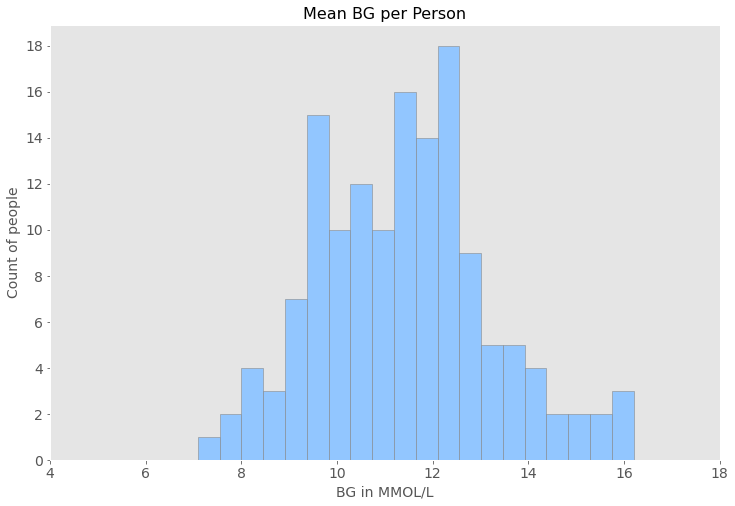

In [161]:
CGMDf.head()
BGbyPerson = CGMDf.groupby('PtID').agg({'ValueMMOL': ['mean', 'min', 'max','std']})
BGbyPerson.reset_index(inplace=True)
BGbyPerson
BGbyPerson.ValueMMOL.mean
AA = BGbyPerson.droplevel(0, axis=1)
fig = pyplot.figure()
AA['mean'].hist(bins=20, figsize=(12,8), grid=False,xlabelsize=14,ylabelsize=14,edgecolor='grey')
pyplot.title('Mean BG per Person', fontsize='16',color='black')
pyplot.xlabel('BG in MMOL/L',fontsize='14')
pyplot.ylabel('Count of people',fontsize='14')

plt.xticks(np.arange(4, 20, 2))
plt.yticks(np.arange(0, 20, 2))

#pyplot.savefig('/Users/bsw/Documents/MRPLocal/Figures/MeanBGperPerson.jpg',)
pyplot.show()

In [114]:
d = pd.DataFrame(CGMDf.groupby(['PtID','series_id'])['RecID'].count())
d.reset_index(inplace=True)
srStats={} ## series stat dictionary

srStats['series_mean'] = d.RecID.mean()
srStats['series_max'] = d.RecID.max()
srStats['series_min'] = d.RecID.min()
srStats

{'series_mean': 109.63116182339385, 'series_max': 1258, 'series_min': 26}

In [116]:
td = pd.DataFrame(srStats.items(),columns=['metric','value'])
td

,metric,value
0,series_mean,109.631162
1,series_max,1258.000000
2,series_min,26.000000


### Ideas

Glucose
Average Glucose by person
min and max per person

Series stats
Series length
Series Min and Max



In [111]:
ptStats

{'number_of_people': 144,
 'number_of_series_per_person_mean': 123.54861111111111,
 'number_of_series_per_person_max': 596,
 'number_of_series_per_person_min': 1}

In [109]:
c = pd.DataFrame(CGMDf.groupby(['PtID','series_id'])['RecID'].count())
c.reset_index(inplace=True)
c.groupby(['PtID'])['RecID'].count().mean()

123.54861111111111

In [103]:
ptStats

{'number_of_people': 144}

In [65]:
grpPTandSeries = pd.DataFrame(CGMDf.groupby(['PtID','series_id'])['RecID'].count()) ## number of people in the file
grpPTandSeries[grpPTandSeries['RecID']<=100000].shape[0]

## Remove the sequences less than 10, they will be useless, create stats based on that.

35561

array([[<AxesSubplot:title={'center':'RecID'}>]], dtype=object)

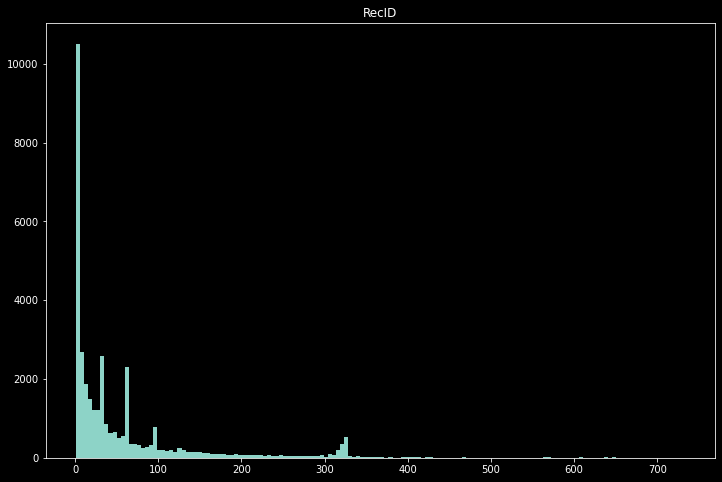

In [62]:
grpPTandSeries[grpPTandSeries['RecID'].between(0,800)].hist(bins=150,figsize=(12,8), grid=False)

In [29]:
CGMDf.groupby(['PtID'])['RecID'].count().max()

#CGMDf.groupby(['PtID','series_id'])['RecID'].count()

58276